In [1]:
import sklearn
import skimage
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.decomposition import IncrementalPCA
from PIL import Image
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import block_reduce
from scipy.stats import gmean
import os
import glob

In [2]:
def get_tile_x(image_number): #Gets the horizontal position of the tile (0 on the left)
    return np.mod(image_number,horizontal_number)

In [3]:
def get_tile_y(image_number): #Gets the vertical position of the tile (0 at the top)
    return np.floor_divide(image_number,horizontal_number)

In [4]:
def get_tile_point(image_number): #Gets the horizontal and vertical positions of the tile as a tuple of the form (hori, vert), 0,0 in top left
    return (np.mod(image_number,horizontal_number),np.floor_divide(image_number,horizontal_number))


In [5]:
def get_tile_number(tile_point): #Gets the number of a tile from its point in the grid
    return(tile_point[0]+horizontal_number*tile_point[1])


In [6]:
def check_stitched_brightness_position(point,x_size, y_size, bright): #Plots a square on the image so that it is possible to see exactly where is being searched
    image = stitched
    colours = [0, 0.8]
    colour = colours[bright] #0 marks a dark square, 1 marks a bright square
    x = point[0]
    y = point[1]
    image[y+y_size, (x-x_size):(x+x_size)] = colour
    image[y-y_size, (x-x_size):(x+x_size)] = colour
    image[(y-y_size):(y+y_size), x+x_size] = colour
    image[(y-y_size):(y+y_size), x-x_size] = colour
    print("Comparison location:", point, " Size: ", x_size, " x ", y_size , " rectangle drawn")
    #return np.median(brightness_array)

In [7]:
def check_brightness_position(image_number,point,x_size, y_size, bright): #Plots a square on the image so that it is possible to see exactly where is being searched
    image = ims_brightened[image_number]
    colours = [0, 0.8]
    colour = colours[bright] #0 marks a dark square, 1 marks a bright square
    x = point[0]
    y = point[1]
    image[y+y_size, (x-x_size):(x+x_size)] = colour
    image[y-y_size, (x-x_size):(x+x_size)] = colour
    image[(y-y_size):(y+y_size), x+x_size] = colour
    image[(y-y_size):(y+y_size), x-x_size] = colour
    print("Image number: ", image_number, " Comparison location:", point, " Size: ", x_size, " x ", y_size , " rectangle drawn")
    #return np.median(brightness_array)

In [8]:
def get_stitched_brightness(point,x_size, y_size): #Gets the mean brightness of a square extending size units out in each direction 
    image = stitched #This takes the point in the form x-y, this is a mistake but is also fine
    x = point[0]
    y = point[1]
    brightness_array = []
    for i in range((2*y_size)+1):
        for j in range((2*x_size)+1):
            brightness_array.append(image[y-y_size+i][x-x_size+j])
            #print(y-size+i, x-size+j, image[y-size+i][x-size+j])
    brightness_array = np.array(brightness_array)
    confidence = len(brightness_array[brightness_array>(40/256)])
    if confidence != 0:
        mean_of_brights = np.mean(brightness_array[brightness_array>(40/256)])
    else:
        mean_of_brights = -999
    #print("Image number: ", image_number, " Comparison location:", point, " Size: ", x_size, " x ", y_size , " Brightness: ", mean_of_brights)
    
    return mean_of_brights, confidence

In [9]:
def get_brightness(image_number,point,x_size, y_size): #Gets the mean brightness of a square extending size units out in each direction 
    image = ims_brightened[image_number] #This takes the point in the form x-y, this is a mistake but is also fine
    x = point[0]
    y = point[1]
    brightness_array = []
    for i in range((2*y_size)+1):
        for j in range((2*x_size)+1):
            brightness_array.append(image[y-y_size+i][x-x_size+j])
            #print(y-size+i, x-size+j, image[y-size+i][x-size+j])
    brightness_array = np.array(brightness_array)
    confidence = len(brightness_array[brightness_array>(40/256)])
    if confidence != 0:
        mean_of_brights = np.mean(brightness_array[brightness_array>(40/256)])
    else:
        mean_of_brights = -999
    #print("Image number: ", image_number, " Comparison location:", point, " Size: ", x_size, " x ", y_size , " Brightness: ", mean_of_brights)
    
    return mean_of_brights, confidence
    #return np.median(brightness_array)

In [10]:
def check_get_brightness_position(image_1_point, image_2_point): #Replica of the point selection logic but instead marks the points
    
    tile_1_x = image_1_point[0] #Legacy from the version of this function which used image numbers
    tile_1_y = image_1_point[1]
    tile_2_x = image_2_point[0]
    tile_2_y = image_2_point[1]
    image_1_number = get_tile_number(image_1_point)
    image_2_number = get_tile_number(image_2_point)
    #tile_1_x = get_tile_x(image_1_number) 
    #tile_1_y = get_tile_y(image_1_number)
    #tile_2_x = get_tile_x(image_2_number)
    #tile_2_y = get_tile_y(image_2_number)
    
    
    #Locations of the centres of the edges of any given tile
    right_edge = np.array((ims[0].shape[1]-1,ims[0].shape[0]/2))
    left_edge = np.array((0,ims[0].shape[0]/2))
    bottom_edge = np.array((ims[0].shape[1]/2,ims[0].shape[0]-1))
    top_edge = np.array((ims[0].shape[1]/2,0))
    
    #I apologise but this is going to be sign hell
    
    
    #Unless something very strange happens the limiting dimension of left-right comparison area sizes will be the width of the overlap area, and top-bottom sizes will be limited by the height
    overlap_area_width = horizontal_overlap + np.sign(tile_1_x-tile_2_x)*(horizontal_columnwise_tuning[tile_1_x] - horizontal_columnwise_tuning[tile_2_x])
    overlap_area_height = vertical_overlap + np.sign(tile_1_y-tile_2_y)*(vertical_rowwise_tuning[tile_1_y] - vertical_rowwise_tuning[tile_2_y])
    #The above only apply when the overlap is primarily left-right and top-bottom, respectively
    
    
    #Pre computing tuning values to keep them out of the if nest for clarity
    tuning_x = horizontal_columnwise_tuning[tile_1_x] - horizontal_columnwise_tuning[tile_2_x] + horizontal_rowwise_tuning[tile_1_y] - horizontal_rowwise_tuning[tile_2_y]
    tuning_y = vertical_columnwise_tuning[tile_1_x] - vertical_columnwise_tuning[tile_2_x] + vertical_rowwise_tuning[tile_1_y] - vertical_rowwise_tuning[tile_2_y]
    
    #tuning x and tuning y are the "leftness" and "upness" of the primary tile relative to the secondary
    #They should be ADDED to the primary edge-secondary edge vector because greater primary leftness means the vector needs to be more rightward
    #similarly greater primary upness means the primary edge-secondary edge vector needs a greater downward component
    #This vector flip is inherited from the tile positioning logic
    
    #When the tiles are placed directly next to eachother with edges aligned, this is the vector from primary edge point to secondary edge point
    nudge = np.array([(tile_2_x-tile_1_x), (tile_2_y-tile_1_y)])
    
    #Goal is to find the vector from the relevant edge of the primary tile to the relevant edge of the secondary tile
    #Find the midpoint of that vector
    #Find that point in both image coordinate systems
    
    if abs(tile_1_x-tile_2_x) == 1 and tile_1_y-tile_2_y == 0: #if tiles are left-right adjacent
        
        relative_y = tuning_y #the y component of the primary edge-secondary edge vector in stitched space
        relative_x = (np.sign(tile_1_x-tile_2_x)*overlap_area_width) + nudge[0] #the x component
        edge_edge_vector = np.array((relative_x, relative_y)) #Vector from the relevant edge of the primary tile to the relevant edge of the secondary tile in stitched space
        x_size_limit = int(np.floor((overlap_area_width-1)/2)) #if odd this needs to just be the floor of the half, but if even it needs to be 1 less than the floor of the half, this achieves that 
        y_size_limit = int(np.floor(((ims[0].shape[0] - abs(tuning_y))-1)/2)) 
        if tile_1_x > tile_2_x: #tile 1 is on the right of tile 2
            
            tile_1_point = left_edge + np.floor(edge_edge_vector/2) #in a case where this vector is odd, these must be rounded to avoid looking for fractional pixels,
            tile_2_point = right_edge - np.ceil(edge_edge_vector/2) #without floor and ceil the target pixels would be next to eachother instead of on top
        
        if tile_1_x < tile_2_x: #tile 1 is on the left of tile 2
            
            tile_1_point = right_edge + np.floor(edge_edge_vector/2)
            tile_2_point = left_edge - np.ceil(edge_edge_vector/2)
            
    elif abs(tile_1_y-tile_2_y) == 1 and tile_1_x-tile_2_x == 0: #if tiles are top-bottom adjacent
        
        relative_x = tuning_x #the x component of the primary edge-secondary edge vector in stitched space
        relative_y = (np.sign(tile_1_y-tile_2_y)*overlap_area_height) + nudge[1] #the y component
        edge_edge_vector = np.array((relative_x, relative_y)) #Vector from the relevant edge of the primary tile to the relevant edge of the secondary tile in stitched space
        y_size_limit = int(np.floor((overlap_area_height-1)/2))
        x_size_limit = int(np.floor(((ims[0].shape[1] - abs(tuning_x))-1)/2)) 
        if tile_1_y > tile_2_y: #tile 1 is below tile 2
            
            tile_1_point = top_edge + np.floor(edge_edge_vector/2) #in a case where this vector is odd, these must be rounded to avoid looking for fractional pixels,
            tile_2_point = bottom_edge - np.ceil(edge_edge_vector/2) #without floor and ceil the target pixels would be next to eachother instead of on top
        
        if tile_1_y < tile_2_y: #tile 1 is above tile 2
            
            tile_1_point = bottom_edge + np.floor(edge_edge_vector/2)
            tile_2_point = top_edge - np.ceil(edge_edge_vector/2)
            
    else:
        print("WARNING: images ", image_1_number, " and ", image_2_number, " sent to get_brightness_factor do not share an edge")
        return 1
    
    #look_here = np.array((1,1)) - abs(nudge)
    #for i in range(5):
    #    tile_1_point_final = tile_1_point + (size_limit*2*look_here*(3-i))
    #    tile_2_point_final = tile_2_point + (size_limit*2*look_here*(3-i))
    #    tile_1_point_final = tuple(map(int, tile_1_point_final)) #Convert the tuples of floats made above into tuples of integers
    #    tile_2_point_final = tuple(map(int, tile_2_point_final))
    #    check_brightness_position(image_1_number, tile_1_point_final, size_limit, 1)
    #    check_brightness_position(image_2_number, tile_2_point_final, size_limit, 0)
    
    
    tile_1_point = tuple(map(int, tile_1_point)) #Convert the tuples of floats made above into tuples of integers
    tile_2_point = tuple(map(int, tile_2_point))
    check_brightness_position(image_1_number, tile_1_point, x_size_limit, y_size_limit, 1)
    check_brightness_position(image_2_number, tile_2_point, x_size_limit, y_size_limit, 0)
    

In [11]:
def stitcher_brightness_evaluator(image_1_point, image_2_point): #Gets the factor by which image 2's brightnesses must be scaled to match image 1
    
    tile_1_x = image_1_point[0] #Legacy from the version of this function which used image numbers
    tile_1_y = image_1_point[1]
    tile_2_x = image_2_point[0]
    tile_2_y = image_2_point[1]
    image_1_number = get_tile_number(image_1_point)
    image_2_number = get_tile_number(image_2_point)
    #tile_1_x = get_tile_x(image_1_number) 
    #tile_1_y = get_tile_y(image_1_number)
    #tile_2_x = get_tile_x(image_2_number)
    #tile_2_y = get_tile_y(image_2_number)
    
    
    #Locations of the centres of the edges of any given tile
    right_edge = np.array((ims[0].shape[1]-1,ims[0].shape[0]/2))
    left_edge = np.array((0,ims[0].shape[0]/2))
    bottom_edge = np.array((ims[0].shape[1]/2,ims[0].shape[0]-1))
    top_edge = np.array((ims[0].shape[1]/2,0))
    
    #I apologise but this is going to be sign hell
    
    
    #Unless something very strange happens the limiting dimension of left-right comparison area sizes will be the width of the overlap area, and top-bottom sizes will be limited by the height
    overlap_area_width = horizontal_overlap + np.sign(tile_1_x-tile_2_x)*(horizontal_columnwise_tuning[tile_1_x] - horizontal_columnwise_tuning[tile_2_x])
    overlap_area_height = vertical_overlap + np.sign(tile_1_y-tile_2_y)*(vertical_rowwise_tuning[tile_1_y] - vertical_rowwise_tuning[tile_2_y])
    #The above only apply when the overlap is primarily left-right and top-bottom, respectively
    
    
    #Pre computing tuning values to keep them out of the if nest for clarity
    tuning_x = horizontal_columnwise_tuning[tile_1_x] - horizontal_columnwise_tuning[tile_2_x] + horizontal_rowwise_tuning[tile_1_y] - horizontal_rowwise_tuning[tile_2_y]
    tuning_y = vertical_columnwise_tuning[tile_1_x] - vertical_columnwise_tuning[tile_2_x] + vertical_rowwise_tuning[tile_1_y] - vertical_rowwise_tuning[tile_2_y]
    
    #tuning x and tuning y are the "leftness" and "upness" of the primary tile relative to the secondary
    #They should be ADDED to the primary edge-secondary edge vector because greater primary leftness means the vector needs to be more rightward
    #similarly greater primary upness means the primary edge-secondary edge vector needs a greater downward component
    #This vector flip is inherited from the tile positioning logic
    
    #When the tiles are placed directly next to eachother with edges aligned, this is the vector from primary edge point to secondary edge point
    nudge = np.array([(tile_2_x-tile_1_x), (tile_2_y-tile_1_y)])
    
    #Goal is to find the vector from the relevant edge of the primary tile to the relevant edge of the secondary tile
    #Find the midpoint of that vector
    #Find that point in both image coordinate systems
    
    if abs(tile_1_x-tile_2_x) == 1 and tile_1_y-tile_2_y == 0: #if tiles are left-right adjacent
        
        relative_y = tuning_y #the y component of the primary edge-secondary edge vector in stitched space
        relative_x = (np.sign(tile_1_x-tile_2_x)*overlap_area_width) + nudge[0] #the x component
        edge_edge_vector = np.array((relative_x, relative_y)) #Vector from the relevant edge of the primary tile to the relevant edge of the secondary tile in stitched space
        x_size_limit = int(np.floor((overlap_area_width-1)/2)) #if odd this needs to just be the floor of the half, but if even it needs to be 1 less than the floor of the half, this achieves that 
        y_size_limit = int(np.floor(((ims[0].shape[0] - abs(tuning_y))-1)/2)) 
        if tile_1_x > tile_2_x: #tile 1 is on the right of tile 2
            
            tile_1_point = left_edge + np.floor(edge_edge_vector/2) #in a case where this vector is odd, these must be rounded to avoid looking for fractional pixels,
            tile_2_point = right_edge - np.ceil(edge_edge_vector/2) #without floor and ceil the target pixels would be next to eachother instead of on top
        
        if tile_1_x < tile_2_x: #tile 1 is on the left of tile 2
            
            tile_1_point = right_edge + np.floor(edge_edge_vector/2)
            tile_2_point = left_edge - np.ceil(edge_edge_vector/2)
            
    elif abs(tile_1_y-tile_2_y) == 1 and tile_1_x-tile_2_x == 0: #if tiles are top-bottom adjacent
        
        relative_x = tuning_x #the x component of the primary edge-secondary edge vector in stitched space
        relative_y = (np.sign(tile_1_y-tile_2_y)*overlap_area_height) + nudge[1] #the y component
        edge_edge_vector = np.array((relative_x, relative_y)) #Vector from the relevant edge of the primary tile to the relevant edge of the secondary tile in stitched space
        y_size_limit = int(np.floor((overlap_area_height-1)/2))
        x_size_limit = int(np.floor(((ims[0].shape[1] - abs(tuning_x))-1)/2)) 
        if tile_1_y > tile_2_y: #tile 1 is below tile 2
            
            tile_1_point = top_edge + np.floor(edge_edge_vector/2) #in a case where this vector is odd, these must be rounded to avoid looking for fractional pixels,
            tile_2_point = bottom_edge - np.ceil(edge_edge_vector/2) #without floor and ceil the target pixels would be next to eachother instead of on top
        
        if tile_1_y < tile_2_y: #tile 1 is above tile 2
            
            tile_1_point = bottom_edge + np.floor(edge_edge_vector/2)
            tile_2_point = top_edge - np.ceil(edge_edge_vector/2)
            
    else:
        print("WARNING: images ", image_1_number, " and ", image_2_number, " sent to get_brightness_factor do not share an edge")
        return 1
    
    #look_here = np.array((1,1)) - abs(nudge)
    #for i in range(5):
    #    tile_1_point_final = tile_1_point + (size_limit*2*look_here*(3-i))
    #    tile_2_point_final = tile_2_point + (size_limit*2*look_here*(3-i))
    #    tile_1_point_final = tuple(map(int, tile_1_point_final)) #Convert the tuples of floats made above into tuples of integers
    #    tile_2_point_final = tuple(map(int, tile_2_point_final))
    #    check_brightness_position(image_1_number, tile_1_point_final, size_limit, 1)
    #    check_brightness_position(image_2_number, tile_2_point_final, size_limit, 0)
    
    
    tile_1_point = tuple(map(int, tile_1_point)) #Convert the tuples of floats made above into tuples of integers
    tile_2_point = tuple(map(int, tile_2_point))
    tile_1_brightness, tile_1_confidence = get_brightness(image_1_number, tile_1_point, x_size_limit, y_size_limit-70)
    tile_2_brightness, tile_2_confidence = get_brightness(image_2_number, tile_2_point, x_size_limit, y_size_limit-70)
    
    
    return tile_1_brightness, tile_2_brightness, tile_1_point, x_size_limit, y_size_limit

In [12]:
def get_brightness_factor(image_1_point, image_2_point): #Gets the factor by which image 2's brightnesses must be scaled to match image 1
    
    tile_1_x = image_1_point[0] #Legacy from the version of this function which used image numbers
    tile_1_y = image_1_point[1]
    tile_2_x = image_2_point[0]
    tile_2_y = image_2_point[1]
    image_1_number = get_tile_number(image_1_point)
    image_2_number = get_tile_number(image_2_point)
    #tile_1_x = get_tile_x(image_1_number) 
    #tile_1_y = get_tile_y(image_1_number)
    #tile_2_x = get_tile_x(image_2_number)
    #tile_2_y = get_tile_y(image_2_number)
    
    
    #Locations of the centres of the edges of any given tile
    right_edge = np.array((ims[0].shape[1]-1,ims[0].shape[0]/2))
    left_edge = np.array((0,ims[0].shape[0]/2))
    bottom_edge = np.array((ims[0].shape[1]/2,ims[0].shape[0]-1))
    top_edge = np.array((ims[0].shape[1]/2,0))
    
    #I apologise but this is going to be sign hell
    
    
    #Unless something very strange happens the limiting dimension of left-right comparison area sizes will be the width of the overlap area, and top-bottom sizes will be limited by the height
    overlap_area_width = horizontal_overlap + np.sign(tile_1_x-tile_2_x)*(horizontal_columnwise_tuning[tile_1_x] - horizontal_columnwise_tuning[tile_2_x])
    overlap_area_height = vertical_overlap + np.sign(tile_1_y-tile_2_y)*(vertical_rowwise_tuning[tile_1_y] - vertical_rowwise_tuning[tile_2_y])
    #The above only apply when the overlap is primarily left-right and top-bottom, respectively
    
    
    #Pre computing tuning values to keep them out of the if nest for clarity
    tuning_x = horizontal_columnwise_tuning[tile_1_x] - horizontal_columnwise_tuning[tile_2_x] + horizontal_rowwise_tuning[tile_1_y] - horizontal_rowwise_tuning[tile_2_y]
    tuning_y = vertical_columnwise_tuning[tile_1_x] - vertical_columnwise_tuning[tile_2_x] + vertical_rowwise_tuning[tile_1_y] - vertical_rowwise_tuning[tile_2_y]
    
    #tuning x and tuning y are the "leftness" and "upness" of the primary tile relative to the secondary
    #They should be ADDED to the primary edge-secondary edge vector because greater primary leftness means the vector needs to be more rightward
    #similarly greater primary upness means the primary edge-secondary edge vector needs a greater downward component
    #This vector flip is inherited from the tile positioning logic
    
    #When the tiles are placed directly next to eachother with edges aligned, this is the vector from primary edge point to secondary edge point
    nudge = np.array([(tile_2_x-tile_1_x), (tile_2_y-tile_1_y)])
    
    #Goal is to find the vector from the relevant edge of the primary tile to the relevant edge of the secondary tile
    #Find the midpoint of that vector
    #Find that point in both image coordinate systems
    
    if abs(tile_1_x-tile_2_x) == 1 and tile_1_y-tile_2_y == 0: #if tiles are left-right adjacent
        
        relative_y = tuning_y #the y component of the primary edge-secondary edge vector in stitched space
        relative_x = (np.sign(tile_1_x-tile_2_x)*overlap_area_width) + nudge[0] #the x component
        edge_edge_vector = np.array((relative_x, relative_y)) #Vector from the relevant edge of the primary tile to the relevant edge of the secondary tile in stitched space
        x_size_limit = int(np.floor((overlap_area_width-1)/2)) #if odd this needs to just be the floor of the half, but if even it needs to be 1 less than the floor of the half, this achieves that 
        y_size_limit = int(np.floor(((ims[0].shape[0] - abs(tuning_y))-1)/2)) 
        if tile_1_x > tile_2_x: #tile 1 is on the right of tile 2
            
            tile_1_point = left_edge + np.floor(edge_edge_vector/2) #in a case where this vector is odd, these must be rounded to avoid looking for fractional pixels,
            tile_2_point = right_edge - np.ceil(edge_edge_vector/2) #without floor and ceil the target pixels would be next to eachother instead of on top
        
        if tile_1_x < tile_2_x: #tile 1 is on the left of tile 2
            
            tile_1_point = right_edge + np.floor(edge_edge_vector/2)
            tile_2_point = left_edge - np.ceil(edge_edge_vector/2)
            
    elif abs(tile_1_y-tile_2_y) == 1 and tile_1_x-tile_2_x == 0: #if tiles are top-bottom adjacent
        
        relative_x = tuning_x #the x component of the primary edge-secondary edge vector in stitched space
        relative_y = (np.sign(tile_1_y-tile_2_y)*overlap_area_height) + nudge[1] #the y component
        edge_edge_vector = np.array((relative_x, relative_y)) #Vector from the relevant edge of the primary tile to the relevant edge of the secondary tile in stitched space
        y_size_limit = int(np.floor((overlap_area_height-1)/2))
        x_size_limit = int(np.floor(((ims[0].shape[1] - abs(tuning_x))-1)/2)) 
        if tile_1_y > tile_2_y: #tile 1 is below tile 2
            
            tile_1_point = top_edge + np.floor(edge_edge_vector/2) #in a case where this vector is odd, these must be rounded to avoid looking for fractional pixels,
            tile_2_point = bottom_edge - np.ceil(edge_edge_vector/2) #without floor and ceil the target pixels would be next to eachother instead of on top
        
        if tile_1_y < tile_2_y: #tile 1 is above tile 2
            
            tile_1_point = bottom_edge + np.floor(edge_edge_vector/2)
            tile_2_point = top_edge - np.ceil(edge_edge_vector/2)
            
    else:
        print("WARNING: images ", image_1_number, " and ", image_2_number, " sent to get_brightness_factor do not share an edge")
        return 1
    
    #look_here = np.array((1,1)) - abs(nudge)
    #for i in range(5):
    #    tile_1_point_final = tile_1_point + (size_limit*2*look_here*(3-i))
    #    tile_2_point_final = tile_2_point + (size_limit*2*look_here*(3-i))
    #    tile_1_point_final = tuple(map(int, tile_1_point_final)) #Convert the tuples of floats made above into tuples of integers
    #    tile_2_point_final = tuple(map(int, tile_2_point_final))
    #    check_brightness_position(image_1_number, tile_1_point_final, size_limit, 1)
    #    check_brightness_position(image_2_number, tile_2_point_final, size_limit, 0)
    
    
    tile_1_point = tuple(map(int, tile_1_point)) #Convert the tuples of floats made above into tuples of integers
    tile_2_point = tuple(map(int, tile_2_point))
    tile_1_brightness, tile_1_confidence = get_brightness(image_1_number, tile_1_point, x_size_limit, y_size_limit)
    tile_2_brightness, tile_2_confidence = get_brightness(image_2_number, tile_2_point, x_size_limit, y_size_limit)
    
    
    
    return tile_2_brightness/tile_1_brightness, (tile_1_confidence+tile_2_confidence)/2
    
    
    
            

In [31]:
#ims_brightened[14].shape

In [32]:
#get_tile_point(13)

In [33]:
#get_brightness_factor(get_tile_point(188), get_tile_point(199))

In [13]:
def do_tile(image_point, done_tracker): #Calibrates the brightness of a given tile
    working_ratios = []
    working_confidences = []
    adjustment_list = np.array([np.array([0, -1]), np.array([1, 0]), np.array([0, 1]), np.array([-1, 0])]) 
    
    for i in range(4):
        neighbour_in_question_point = image_point+adjustment_list[i] #consider a neighbour
        if neighbour_in_question_point[0] < horizontal_number and neighbour_in_question_point[0] >=0 and neighbour_in_question_point[1] <vertical_number and neighbour_in_question_point[1] >= 0:  
            if done_tracker[neighbour_in_question_point[0], neighbour_in_question_point[1]] == 1: #if it has been done
                ratio, confidence = get_brightness_factor(neighbour_in_question_point, image_point) #list the factor between the tile and neighbour
                working_ratios.append(ratio)
                working_confidences.append(confidence)
                #check_get_brightness_position(neighbour_in_question_point, image_point) #debugging tool which marks where the brightness factor finder is looking
    working_ratios = np.array(working_ratios)
    working_confidences = np.array(working_confidences)
    overall_ratio = np.sum(working_ratios*working_confidences)/np.sum(working_confidences)
    
    #if len(working_ratios)>=1: 
    #    overall_ratio = np.median(working_ratios) 
    #   print(overall_ratio)
    #else:
    #    overall_ratio = 1
    #    print("BADBADBADBAD")
        
    #take median, this is simple but might work fairly nicely, the nuclear option would be to least squares fit, which in the case of 1 or 2 neighbours (most common) is identical, and this may help avoid outliers in 3 or 4-neighbour cases
    ims_brightened[get_tile_number(image_point)] = ims[get_tile_number(image_point)]*overall_ratio
    
    done_tracker[image_point[0]][ image_point[1]] += 1 #Mark tile as done
    brightness_tracker[image_point[0]][ image_point[1]] += overall_ratio #debugging tool
    
    
    return done_tracker

In [14]:
def find_done_neighbour_numbers(done_tracker):
    #Yes I'm iterating over the whole thing instead of being selective what of it
    neighbour_tracker = np.zeros((horizontal_number, vertical_number))
    for i in range(horizontal_number):
        for j in range(vertical_number):
            if done_tracker[i][j] == 1:
                #print(i," ",j)
                neighbours = np.array([np.array([i, j-1]), np.array([i+1, j]), np.array([i, j+1]), np.array([i-1, j])]) 
                for k in range(4):
                    if neighbours[k][0] < horizontal_number and neighbours[k][0] >=0 and neighbours[k][1] <vertical_number and neighbours[k][1] >= 0:
                        #print(neighbours[k])
                        neighbour_tracker[neighbours[k][0], neighbours[k][1]] +=1
    #clean up, since done tiles might otherwise be the tiles with the most neighbours
    for i in range(horizontal_number):
        for j in range(vertical_number):
            if done_tracker[i][j] != 0:
                neighbour_tracker[i][j] = 0
    return neighbour_tracker
            
            
            

In [15]:
def get_origins(inboard_layout):
    origin_numbers = []
    origin_layout = layout.copy()
    for i in range(origin_layout.shape[0]-2):
        for j in range(origin_layout.shape[1]-2):
            origin_layout[i+1, j+1] = np.sum(inboard_layout[i:i+3, j:j+3])
    valid_origins = origin_layout==9
    origin_points = np.argwhere((valid_origins == 1))
    for i in origin_points:
        origin_numbers.append(get_tile_number(i))
    
    return origin_numbers

In [16]:
def propagate_brightness(origins):
    number_of_runs_to_average = 10 #per origin
    brightness_tracker_set = np.zeros((number_of_runs_to_average*len(origins), horizontal_number, vertical_number))
    for j in range(len(origins)):
        start_tile_number = origins[j]
        for i in range(number_of_runs_to_average):

            global ims_brightened
            ims_brightened = ims.copy()
            done_tracker = np.zeros((horizontal_number, vertical_number))
            done_tracker[get_tile_point(start_tile_number)] = 1
            global brightness_tracker
            brightness_tracker = np.zeros((horizontal_number, vertical_number))
            brightness_tracker[get_tile_point(start_tile_number)] = 1

            #for i in range(10):
            while np.min(done_tracker) == 0:
                neighbour_array = find_done_neighbour_numbers(done_tracker)
                #print(neighbour_array)
                #tile_with_most_neighbours = np.unravel_index(neighbour_array.argmax(), neighbour_array.shape)
                #print(tile_with_most_neighbours)
                #find list of indices of tiles with highest number of neighbours, instead of just the first instance which produces a top-left bias
                inboard_neighbours = neighbour_array*inboard_layout
                edge_neighbours = neighbour_array*edge_layout
                black_neighbours = neighbour_array*black_layout
                
                if np.max(inboard_neighbours) >0:
                    options = np.argwhere((inboard_neighbours == np.max(inboard_neighbours)))
                elif np.max(edge_neighbours) >0:
                    options = np.argwhere((edge_neighbours == np.max(edge_neighbours)))
                else:
                    options = np.argwhere((black_neighbours == np.max(black_neighbours)))
                    
                
                #options = np.argwhere((neighbour_array == np.max(neighbour_array)))
                #print(options)
                selected = np.array(options[np.random.randint(0, options.shape[0])])
                #print(selected)
                done_tracker = do_tile(selected, done_tracker)
                #print(done_tracker)
            print(brightness_tracker)
            token_number = i+(number_of_runs_to_average*j)
            brightness_tracker_set[token_number] =  brightness_tracker
            print(token_number, " out of ", number_of_runs_to_average*len(origins))

    
    #global overall_brightness_tracker
    overall_brightness_tracker = np.transpose(gmean(brightness_tracker_set, 0))
    print(overall_brightness_tracker)
    return overall_brightness_tracker
    
    #    primary_x = get_tile_x(start_tile)
    #    primary_y = get_tile_y(start_tile)
    #    side_codes = np.array(["Top", "Right", "Bottom", "Left"])
    #    #top-right-bottom-left
    #    edge_buds = np.array([np.array([primary_x, primary_y-1]), np.array([primary_x+1, primary_y]), np.array([primary_x, primary_y+1]), np.array([primary_x-1, primary_y])]) 
    #    #progress
    #    print(edge_buds)
    #    for i in range(4): #build the initial edges
    #        build_new_edge(edge_buds[i], side_codes[i])
    #        
    #    build_corners(edge_buds) #build the corners




        #print(done_tracker)

In [17]:
def apply_factor_brightness(brightness_array):

    ims_reshaped = ims.copy()   
    ims_reshaped = np.reshape(ims_reshaped, (vertical_number, horizontal_number, ims[0].shape[0], ims[0].shape[1]))
    ims_brightened_overall = np.zeros((vertical_number, horizontal_number, ims[0].shape[0], ims[0].shape[1]))
    for i in range(vertical_number):
        for j in range(horizontal_number):
            ims_brightened_overall[i,j] = ims_reshaped[i,j]*brightness_array[i,j]
    return ims_brightened_overall

In [18]:
def apply_offset_brightness(brightness_array):

    ims_reshaped = ims.copy()   
    ims_reshaped = np.reshape(ims_reshaped, (vertical_number, horizontal_number, ims[0].shape[0], ims[0].shape[1]))
    ims_brightened_overall = np.zeros((vertical_number, horizontal_number, ims[0].shape[0], ims[0].shape[1]))
    for i in range(vertical_number):
        for j in range(horizontal_number):
            ims_brightened_overall[i,j] = ims_reshaped[i,j]+brightness_array[i,j]
    return ims_brightened_overall

In [20]:
#overall_brightness_tracker = [[1.11467289, 0.98636859, 1.07209015],
#[1.00737486, 1.00521794, 1.07325913],
#[1.01013662, 1.0071234,  1.00399005],
#[1.00473512, 0.99940295, 1.00713159],
#[0.99118123, 1.01185588, 0.99697581],
#[1.0004881,  0.99553591, 1.00369655],
#[0.99787988, 0.,         1.00049363],
#[0.99926029, 1.00334255, 1.00199146],
#[1.00987232, 1.01606467, 0.99925823],
#[1.1434904,  0.99704298, 1.00797722],
#[1.07872491, 1.01999023, 1.0355848 ]]
#overall_brightness_tracker = np.transpose(np.array(overall_brightness_tracker))

In [30]:
#John3 28/02/24 25 repeats per origin

offset_brightness_tracker = np.array([[        0,         0,  0.01098813, -0.065615  ,  0.09535757,
        -0.10585374, -0.00096045, -0.02316203,         0,         0,
                0,         0,         0,        0,         0,
                0,         0,         0],
       [        0, -0.0081868 , -0.06074132,  0.1099866 ,  0.09392876,
         0.07872575,  0.02238817,  0.0101037 , -0.01314126,         0,
                0,         0,         0,         0,         0,
                0,         0,         0],
       [ 0.00036677, -0.05960863,  0.08773185,  0.10581426,  0.09072009,
         0.07430827,  0.05967989,  0.04048626,  0.02592577,  0.01443175,
         0.00768799,         0,         0,         0,         0,
                0,         0,         0],
       [ 0.00142071,  0.01028123,  0.1153443 ,  0.10086038,  0.08594608,
         0.07054292,  0.05398549,  0.0356074 ,  0.02275003,  0.01312416,
         0.00084632, -0.02031382,  0.00779374, -0.00587494,         0,
                0,         0,         0],
       [-0.03092309,  0.11023831,  0.11074829,  0.09677139,  0.08213493,
         0.06708148,  0.05142712,  0.03459605,  0.02188257,  0.01110825,
        -0.00160097, -0.01399617, -0.02635774, -0.03531265,  0.00901994,
                0,         0,         0],
       [-0.02049233,  0.12019861,  0.10829157,  0.09242132,  0.07752305,
         0.06353474,  0.04904143,  0.03439437,  0.02174831,  0.00936982,
        -0.00357182, -0.0174302 , -0.0318347 , -0.04431913, -0.05114934,
        -0.01278874,  0.00654363,         0],
       [ 0.08631015,  0.11605223,  0.1034622 ,  0.0879015 ,  0.07235292,
         0.05889237,  0.04386927,  0.02974404,  0.01875597,  0.00588669,
        -0.00701794, -0.02048058, -0.03513693, -0.05037073, -0.06385244,
        -0.07712027, -0.08283218,  0.00446582],
       [ 0.07994267,  0.1115242 ,  0.09882898,  0.08401476,  0.06810349,
         0.05307315,  0.03705544,  0.02157905,  0.0137235 ,  0.00313778,
        -0.00972271, -0.0231715 , -0.03880359, -0.05391287, -0.06787816,
        -0.08286896, -0.09428376, -0.10324473],
       [ 0.07378765,  0.10436354,  0.09221125,  0.0793466 ,  0.06327015,
         0.04797038,  0.03160318,  0.01580773,  0.00771254,  0.00296431,
        -0.01167281, -0.02750246, -0.0428381 , -0.05848895, -0.07401369,
        -0.08868657, -0.10032805, -0.10882254],
       [ 0.07013935,  0.09927986,  0.08752124,  0.07507445,  0.05971041,
         0.0442022 ,  0.02795233,  0.01288552,  0.00323757, -0.00178226,
        -0.01679625, -0.03236624, -0.04714617, -0.06214387, -0.07875701,
        -0.09451019, -0.10589591, -0.10903476],
       [ 0.02694536,  0.09187015,  0.08319102,  0.07122115,  0.05608668,
         0.04159197,  0.02638846,  0.01278446,  0.00094928, -0.00873824,
        -0.02210502, -0.03752662, -0.05313118, -0.06753202, -0.08376206,
        -0.09902513, -0.11194613, -0.11467119],
       [-0.03261026,  0.03928164,  0.07807874,  0.06521214,  0.05272749,
         0.03829306,  0.02349017,  0.00903533, -0.00428741, -0.01542756,
        -0.02747763, -0.0430023 , -0.05711722, -0.07278443, -0.08912918,
        -0.10504669, -0.11756584, -0.12023212],
       [-0.00241245, -0.00601133,  0.06389911,  0.06156278,  0.0477502 ,
         0.0343205 ,  0.01953281,  0.00467037, -0.00827882, -0.02032512,
        -0.03234823, -0.04831171, -0.06242694, -0.07789376, -0.09374769,
        -0.1101277 , -0.12141872, -0.12077811],
       [        0, -0.00769773, -0.06987497,  0.02831458,  0.04354981,
         0.02970202,  0.01537187,  0.00127087, -0.01136027, -0.02463517,
        -0.03711098, -0.05126737, -0.06574701, -0.0813403 , -0.09675482,
        -0.11326501, -0.12555844, -0.13678242],
       [        0,         0, -0.00442701, -0.00981706, -0.00378947,
         0.02251486,  0.00874686, -0.00304328, -0.01716601, -0.0267725 ,
        -0.03901269, -0.05528376, -0.06987576, -0.08572118, -0.10066493,
        -0.11603649, -0.13006728, -0.14119318],
       [        0,         0,         0,         0,  0.00333845,
         0.00268731,  0.00054937, -0.00863234, -0.00426956, -0.02770861,
        -0.04194668, -0.05858691, -0.07346005, -0.08982503, -0.10394994,
        -0.11955181, -0.13282864, -0.1421713 ],
       [        0,         0,         0,         0,         0,
                0, -0.00605544,  0.00671465, -0.00034797, -0.03044853,
        -0.0455839 , -0.0606457 , -0.07609931, -0.09040298, -0.10413145,
        -0.12061353, -0.13523134, -0.01694609],
       [        0,         0,         0,         0,         0,
                0,         0,         0,  0.00664912, -0.00832208,
        -0.04711487, -0.06272755, -0.07858179, -0.09234418, -0.10726464,
        -0.12169538, -0.13560961,  0.00189564]])

geo_factor_brightness_tracker = np.array([[1.        , 1.        , 1.11798959, 1.2774484 , 1.25390463,
        1.21859886, 1.03514609, 0.92225119, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [1.        , 0.96716451, 1.29383168, 1.28371652, 1.24415687,
        1.20979156, 1.1766261 , 1.13961801, 0.97176869, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [1.02681023, 1.01043051, 1.31228777, 1.27213072, 1.23241875,
        1.19520659, 1.15947922, 1.1271569 , 1.09874049, 1.0886125 ,
        1.04749403, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [0.98940841, 1.33342656, 1.29806358, 1.25915614, 1.21953327,
        1.18317958, 1.14549055, 1.1101756 , 1.08037411, 1.05048217,
        1.01962672, 0.95792017, 1.01562687, 0.97866837, 1.        ,
        1.        , 1.        , 1.        ],
       [0.96037651, 1.32278955, 1.28489245, 1.24595624, 1.20817955,
        1.17133635, 1.13540623, 1.10146423, 1.06994915, 1.03825739,
        1.00770031, 0.97790137, 0.94977847, 0.92887455, 1.02814969,
        1.        , 1.        , 1.        ],
       [1.32984166, 1.3122072 , 1.27267957, 1.2339768 , 1.19629429,
        1.16056305, 1.12592759, 1.09147016, 1.05910844, 1.0274299 ,
        0.99677914, 0.96612043, 0.93668328, 0.91185946, 0.89266568,
        0.95216211, 1.01637574, 1.        ],
       [1.33413269, 1.29836586, 1.25916753, 1.22007255, 1.18323952,
        1.14916282, 1.11452855, 1.08133747, 1.05063247, 1.01741537,
        0.98723507, 0.95806179, 0.92853813, 0.8994608 , 0.87421522,
        0.84985729, 0.83389722, 0.94452069],
       [1.32735527, 1.28644752, 1.24761343, 1.2098132 , 1.1725843 ,
        1.13681966, 1.10213352, 1.0702316 , 1.03808803, 1.01109062,
        0.97973397, 0.95070361, 0.92076325, 0.89263347, 0.86625888,
        0.83890756, 0.81693308, 0.79828652],
       [1.31422044, 1.27240462, 1.233476  , 1.19783435, 1.16055683,
        1.12487397, 1.08975999, 1.05775775, 1.02594913, 1.003881  ,
        0.97299364, 0.94181666, 0.91247832, 0.88341354, 0.85636764,
        0.83038155, 0.80720998, 0.7903009 ],
       [1.29870039, 1.25869002, 1.22177877, 1.18642105, 1.15010105,
        1.11444327, 1.07951497, 1.04866836, 1.01814376, 0.99446248,
        0.96293407, 0.93251747, 0.90444608, 0.87581519, 0.84770942,
        0.82128527, 0.79871239, 0.78789214],
       [1.27841053, 1.2436304 , 1.2121627 , 1.1759325 , 1.13926606,
        1.10486136, 1.07063519, 1.0389035 , 1.00856069, 0.98330344,
        0.95278781, 0.92301113, 0.89368285, 0.86618769, 0.83905734,
        0.81348801, 0.79014164, 0.77931766],
       [0.94691792, 1.23142555, 1.20010149, 1.16486892, 1.12972857,
        1.09501639, 1.06155167, 1.02869489, 0.99734273, 0.97151119,
        0.94193731, 0.91295646, 0.88573003, 0.85701296, 0.82985865,
        0.80393356, 0.78110788, 0.77053639],
       [1.02181252, 1.21587211, 1.18785685, 1.15302977, 1.1182121 ,
        1.08417479, 1.05108973, 1.0186517 , 0.98784231, 0.96065868,
        0.93270296, 0.90309895, 0.87551492, 0.84784514, 0.82145956,
        0.79524227, 0.77529867, 0.76702991],
       [1.        , 0.99520467, 1.12811628, 1.13987464, 1.10875167,
        1.07293258, 1.04060134, 1.00947699, 0.97958291, 0.95083711,
        0.92415308, 0.89678096, 0.86886083, 0.84125074, 0.81520711,
        0.78914779, 0.7680358 , 0.75011485],
       [1.        , 1.        , 0.97937796, 0.98363701, 1.09268521,
        1.06102127, 1.02632489, 1.00125884, 0.97138729, 0.94428617,
        0.91751896, 0.88737281, 0.85995149, 0.83284002, 0.80794507,
        0.78265428, 0.75953895, 0.74267868],
       [1.        , 1.        , 1.        , 1.        , 1.01999375,
        1.03632817, 1.01664759, 0.99063325, 0.97644265, 0.93849935,
        0.90979736, 0.87964426, 0.85226688, 0.82497861, 0.80114697,
        0.77500357, 0.75487757, 0.73912888],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.9866042 , 1.0253534 , 0.98574532, 0.9305622 ,
        0.90093537, 0.87279635, 0.84431179, 0.81922288, 0.79565418,
        0.76951092, 0.74912698, 0.89150167],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.02264759, 0.94165848,
        0.89452591, 0.86569075, 0.83702714, 0.81219293, 0.78790795,
        0.76580872, 0.74562332, 0.92666802]])

arith_factor_brightness_tracker = np.array([[1.        , 1.        , 1.11785052, 1.2882524 , 1.26512289,
        1.22884541, 1.03506537, 0.92220198, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [1.        , 0.96737721, 1.30375933, 1.2953659 , 1.25542201,
        1.22066913, 1.18718647, 1.14871141, 0.9719623 , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [1.02687936, 1.01058816, 1.32412357, 1.28369185, 1.24359232,
        1.20601884, 1.17001775, 1.137228  , 1.108111  , 1.08964566,
        1.04749272, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [0.99007529, 1.34503048, 1.30987723, 1.27063565, 1.2306601 ,
        1.19397833, 1.1559599 , 1.12022561, 1.09010345, 1.0602117 ,
        1.02900443, 0.96068734, 1.01568985, 0.97891522, 1.        ,
        1.        , 1.        , 1.        ],
       [0.9612023 , 1.33467944, 1.2966431 , 1.25736812, 1.21931964,
        1.18224064, 1.14597585, 1.11165027, 1.07999602, 1.04818325,
        1.0174235 , 0.98736409, 0.95877609, 0.93642841, 1.02859353,
        1.        , 1.        , 1.        ],
       [1.34034118, 1.32428891, 1.28439299, 1.24532966, 1.2073529 ,
        1.17140452, 1.13653569, 1.10184565, 1.06932605, 1.03742608,
        1.00651623, 0.97553859, 0.94576771, 0.92058378, 0.89983642,
        0.95260042, 1.01634959, 1.        ],
       [1.34612497, 1.31030681, 1.27078693, 1.23136452, 1.19420075,
        1.15993299, 1.12504275, 1.09166844, 1.06086288, 1.0274768 ,
        0.99698437, 0.96739377, 0.93749039, 0.90799564, 0.88234459,
        0.85763728, 0.84064587, 0.94481396],
       [1.33934069, 1.29822231, 1.25910019, 1.22102412, 1.18342631,
        1.14738064, 1.11234492, 1.08019467, 1.04797674, 1.0210284 ,
        0.98928994, 0.95969929, 0.92948164, 0.90097813, 0.87420001,
        0.84650088, 0.82420912, 0.80512997],
       [1.32594056, 1.28389117, 1.24459644, 1.208942  , 1.17128712,
        1.13524336, 1.09961265, 1.06711565, 1.03498226, 1.01282052,
        0.98214213, 0.95062556, 0.92100457, 0.89160596, 0.86427111,
        0.83791042, 0.81441639, 0.79708201],
       [1.31008806, 1.27003096, 1.23295324, 1.19748701, 1.16087436,
        1.12487835, 1.08947332, 1.05826355, 1.02751197, 1.00354697,
        0.97188336, 0.94119433, 0.91287444, 0.88385361, 0.85550173,
        0.82874732, 0.80580011, 0.79453045],
       [1.28904996, 1.25471369, 1.22329602, 1.18696572, 1.15003296,
        1.11535554, 1.08080436, 1.04882903, 1.01824752, 0.99248149,
        0.9616525 , 0.93162329, 0.90203101, 0.87414225, 0.8467511 ,
        0.82082553, 0.79716583, 0.78592056],
       [0.94856604, 1.24239081, 1.21112521, 1.17578163, 1.14046627,
        1.10547036, 1.07166835, 1.03846026, 1.00679139, 0.98063876,
        0.95066448, 0.92143239, 0.89391534, 0.86484359, 0.83742892,
        0.81121817, 0.78807701, 0.77710584],
       [1.02203686, 1.22561785, 1.19868773, 1.16387547, 1.12880258,
        1.0945323 , 1.06109796, 1.02827592, 0.997121  , 0.9695776 ,
        0.94126481, 0.91144319, 0.88348656, 0.85548587, 0.82885466,
        0.80238526, 0.78222067, 0.77317558],
       [1.        , 0.99535616, 1.13207754, 1.15022832, 1.11912183,
        1.08314893, 1.05050231, 1.01901188, 0.98887351, 0.95980339,
        0.93267515, 0.90497807, 0.87668685, 0.84875554, 0.82245013,
        0.79616731, 0.77484128, 0.75669857],
       [1.        , 1.        , 0.97969687, 0.98392844, 1.10226041,
        1.07107384, 1.03615583, 1.01081862, 0.9800896 , 0.95269712,
        0.92567696, 0.89534508, 0.86755385, 0.84017332, 0.8150434 ,
        0.78947093, 0.76616283, 0.74913527],
       [1.        , 1.        , 1.        , 1.        , 1.02017175,
        1.03688924, 1.02584555, 1.00004957, 0.9771403 , 0.94666705,
        0.91777569, 0.88738372, 0.85965977, 0.83213393, 0.80802822,
        0.78164749, 0.76139145, 0.74539621],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.98655781, 1.02521435, 0.9860155 , 0.93840434,
        0.90864547, 0.88024276, 0.85142892, 0.8260565 , 0.8022358 ,
        0.77590717, 0.75545234, 0.89198517],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.02261824, 0.9418179 ,
        0.90176937, 0.87282925, 0.84388679, 0.81876543, 0.79438818,
        0.77214942, 0.75175923, 0.92695142]])

In [23]:
brightness_applied = apply_brightness(geo_brightness_tracker)


NameError: name 'apply_brightness' is not defined

In [51]:
ims_brightened = brightness_applied.reshape(horizontal_number*vertical_number, 512, 768)

In [1]:
overall_brightness_tracker = propagate_brightness(-1)

NameError: name 'propagate_brightness' is not defined

In [81]:
acceptable_origins

[35,
 46,
 25,
 36,
 47,
 58,
 69,
 80,
 91,
 102,
 48,
 59,
 70,
 81,
 92,
 103,
 114,
 82,
 93,
 104,
 115,
 126,
 137,
 105,
 116,
 127,
 138,
 149,
 117,
 128,
 139,
 150,
 161,
 172,
 129,
 140,
 151,
 162,
 173]

In [197]:
overall_brightness_tracker

array([[0.98211475, 1.00270343, 0.99446222, 1.00090118, 0.99611049,
        0.99966609, 0.9991536 , 0.99935281, 0.99873047, 0.99188937,
        1.05172841],
       [1.02241214, 0.99604057, 1.00190727, 0.99367371, 0.99958996,
        0.99678639, 1.        , 1.00402169, 0.99870469, 0.99770738,
        1.00212055],
       [1.03145271, 1.00055574, 0.99493901, 1.00301256, 0.99728943,
        0.99940129, 1.00178308, 0.99926955, 1.002661  , 0.99731954,
        1.00209331]])

In [70]:
get_brightness_factor(get_tile_point(7), get_tile_point(8))

(1.0302904, 26.5)

In [69]:
get_brightness_factor(get_tile_point(19), get_tile_point(8))

(1.0329134, 9.0)

In [21]:
#Image import for the stitcher, while I believe this could be done with full resolution images and the code would function, it is untested
#Primarily for computational power (runtime and critically memory) issues

#This is the same classifier as in the paired PCA pre-processing, but slightly less aggressive and with no regard for bright tiles or keeping the masks
#This program should only need the classification, so keeping the masks is a waste of memory
#The classification for edge here is also less strict on the basis that while with the PCA you almost exclusively want tiles which
#are entirely plagioclase, here a 70% plag tile is only marginally less useful than a 90-100% tile, and the increased variety in 
#path for the propagator will aid in smoothing

ims = [plt.imread(path) for path in glob.glob("C:/Users/rwfbl/Tilesets/John3/Preprocessed/*.png")]

ims = np.array(ims)
inboard_tile_numbers = [] #Numbers for the tiles which are considered "inboard", those which are at least 90% sample
black_tile_numbers = [] #Numbers for the tiles which are considered "black", those which are at least 90% empty space without plag
edge_tile_numbers = [] #Numbers for the tiles which are considered "edges", those which are between 

black_threshold_for_classification = 70/256

#manual_ignores = np.array([1, 2, 15, 435, 436, 449, 450, 451, 463, 464, 465, 466, 475, 476])-1 #For John4

for i in range(len(ims)):
    black_mask = ims[i]<black_threshold_for_classification
    if np.mean(black_mask) > 0.9:
        black_tile_numbers.append(i)
    elif np.mean(black_mask) <0.3:
        inboard_tile_numbers.append(i)
    else:
        edge_tile_numbers.append(i)
        

layout = np.zeros((horizontal_number, vertical_number))
inboard_layout = layout.copy()
for i in inboard_tile_numbers:
    point = get_tile_point(i)
    inboard_layout[point] = 1
edge_layout = layout.copy()
for i in edge_tile_numbers:
    point = get_tile_point(i)
    edge_layout[point] = 1   
black_layout = layout.copy()
for i in black_tile_numbers:
    point = get_tile_point(i)
    black_layout[point] = 1 

acceptable_origins = get_origins(inboard_layout)
acceptable_origin_layout = layout.copy()
for i in acceptable_origins:
    point = get_tile_point(i)
    acceptable_origin_layout[point] = 1 

In [31]:
acceptable_origin_layout.shape

(11, 19)

In [48]:
#Debugging left-right weirdness

#There may also be top-bottom weirdness
#top_left_origin = propagate_brightness([25])
#bottom_right__origin = propagate_brightness([114])



In [34]:
geo_mean_ims = 0#apply_factor_brightness(geo_factor_brightness_tracker)
arith_mean_ims = apply_factor_brightness(arith_factor_brightness_tracker)
offset_ims = 0#apply_offset_brightness(offset_brightness_tracker)

In [34]:
bottom_right_ims = apply_brightness(bottom_right__origin)

In [52]:
get_tile_number((15,9))

114

In [51]:
acceptable_origins

[35,
 46,
 25,
 36,
 47,
 58,
 69,
 80,
 91,
 102,
 48,
 59,
 70,
 81,
 92,
 103,
 114,
 82,
 93,
 104,
 115,
 126,
 137,
 105,
 116,
 127,
 138,
 149,
 117,
 128,
 139,
 150,
 161,
 172,
 129,
 140,
 151,
 162,
 173]

In [27]:
from IPython.display import Audio
sound_file = 'C:/Users/rwfbl/Eldritch_Blast.wav'
#Audio(sound_file, autoplay=True)

In [29]:
type(ims[0].shape[1])

int

In [32]:
edge_tile_numbers

[2,
 3,
 12,
 16,
 27,
 33,
 39,
 44,
 50,
 61,
 67,
 73,
 78,
 84,
 89,
 96,
 100,
 108,
 123,
 131,
 135,
 142,
 153,
 158,
 164,
 170,
 175,
 186,
 194,
 197,
 206,
 207]

In [56]:
input_tile_mean = np.mean(ims, 0)
edge_mean = np.mean(ims[edge_tile_numbers], 0)
inboard_mean = np.mean(ims[inboard_tile_numbers], 0)
not_black_mean = np.mean(ims[inboard_tile_numbers+edge_tile_numbers], 0)

18.277442932128906


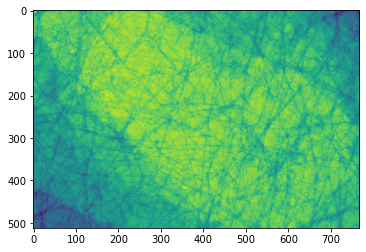

In [57]:
#plt.imshow(input_tile_mean)
#print((np.max(input_tile_mean)-np.min(input_tile_mean))*256)
#plt.imshow(edge_mean)
plt.imshow(inboard_mean)
print((np.max(inboard_mean)-np.min(inboard_mean))*256)

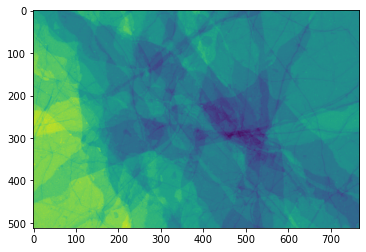

In [58]:
plt.imshow(edge_mean)

In [27]:
#for i in range(300):
  #  print(ims[i].shape)

In [19]:
#For testing subset (rows 9-11 of john1)

#horizontal_overlap = 68
#vertical_overlap = 38
#horizontal_number = 11
#vertical_number = 3
#horizontal_rowwise_tuning = [-13,-21,-32]
#vertical_rowwise_tuning = [57,62,75]


#horizontal_columnwise_tuning = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] #Greater means further to the left
#vertical_columnwise_tuning = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] #Greater means higher

In [56]:
#For John1

#horizontal_overlap = 68
#vertical_overlap = 38
#horizontal_number = 11
#vertical_number = 19
#horizontal_rowwise_tuning = [0,12,20,18,18,13,5,0,-13,-21,-32,-40,-44,-44,-51,-59,-62,-65,-65] #Greater means further to the left
#vertical_rowwise_tuning = [0,0,0,14,14,29,35,40,57,62,75,84,88,99,102,113,120,124,134] #Greater means higher
#horizontal_columnwise_tuning = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] #Greater means further to the left
#vertical_columnwise_tuning = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] #Greater means higher

In [23]:
#For John2

#horizontal_overlap = 76
#vertical_overlap = 38
#horizontal_number = 21
#vertical_number = 19
#horizontal_rowwise_tuning = [0,14,18,15,7,6,1,-4,-17,-28,-40,-50,-56,-60,-61,-69,-72, -75, -78] #Greater means further to the left
#vertical_rowwise_tuning = [0,10,30,37,50,65,71,88,92,104,113,123,140,146,160,169, 180, 192, 199] #Greater means higher
#comment                       [1,   2,  3,  4,   5,   6,   7,   8,   9,   10,   11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21
#horizontal_columnwise_tuning = [0,   0,  -1, -1, -2,  -2,  -2,  -3,  -3,  -3,   -5,   -8,   -14,   -18, -22,  -24,  -27,  -28,  -31,   -31,   -34]
#vertical_columnwise_tuning =   [0,   0,  -1,  -1, -1,  -1,  -1,  -2,  -2,  -2,   -2,   -4,   -5,   -6,   -7,   -5,   -10,   -6,   -6,   -6,   -6]

In [19]:
#For John3

horizontal_overlap = 68
vertical_overlap = 48
horizontal_number = 18
vertical_number = 18
horizontal_rowwise_tuning = [0,-3,-6, -8, -11, -13, -16, -19, -22, -25, -28, -31, -35, -38, -40, -43, -46, -48] #Greater means further to the left
vertical_rowwise_tuning = [0,0,-6, -9, -13, -17, -18, -23, -22, -25, -27, -29, -36, -38, -43, -48, -49, -55] #Greater means higher
#comment                      [1,   2,   3,   4,   5,   6,   7,   8,   9,   10,   11,   12,   13,   14,   15,   16,   17,   18]
horizontal_columnwise_tuning =[0,   -1,   -4,  -7, -10, -12,-12, -13,  -16,  -18, -21,  -23,  -29,  -32,  -36,  -38,   -38, -39]
vertical_columnwise_tuning =  [0,   -3,   -4, -5,  -7,  -8,  -8,  -9,  -16,  -16,  -18,  -16,  -17,  -17, -16,   -17,   -17,   -19]    

In [30]:
#For John4

horizontal_overlap = 68
vertical_overlap = 48
horizontal_number = 34
vertical_number = 14
inst_horizontal_rowwise_tuning = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #Greater means further to the left
inst_vertical_rowwise_tuning = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #Greater means higher
#comment                      [1,   2,   3,   4,   5,   6,   7,   8,   9,   10,   11,   12,   13,   14,   15,   16,   17,   18,   19,   20,  21,   22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34]
inst_horizontal_columnwise_tuning =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
inst_vertical_columnwise_tuning =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

horizontal_rowwise_tuning = []
vertical_rowwise_tuning = []
for i in range(vertical_number):
    horizontal_rowwise_tuning.append(np.sum(inst_horizontal_rowwise_tuning[0:i+1]))
    vertical_rowwise_tuning.append(np.sum(inst_vertical_rowwise_tuning[0:i+1]))

horizontal_columnwise_tuning = []
vertical_columnwise_tuning = []
for i in range(horizontal_number):
    horizontal_columnwise_tuning.append(np.sum(inst_horizontal_columnwise_tuning[0:i+1]))
    vertical_columnwise_tuning.append(np.sum(inst_vertical_columnwise_tuning[0:i+1]))

In [22]:
guidelines = 0
horizontal_size = ims[0].shape[1]
vertical_size = ims[0].shape[0]
starting_row = 0
smallest_horizontal_offset = np.min((np.min(horizontal_rowwise_tuning), np.min(horizontal_columnwise_tuning)))
smallest_vertical_offset = np.min((np.min(vertical_rowwise_tuning), np.min(vertical_columnwise_tuning)))
horizontal_dont_wrap = np.max(horizontal_rowwise_tuning) + np.max(horizontal_columnwise_tuning)
vertical_dont_wrap = np.max(vertical_rowwise_tuning) + np.max(vertical_columnwise_tuning)
total_width = (horizontal_number*ims[0].shape[1]) -(horizontal_number - 1)*horizontal_overlap + np.max((np.max(horizontal_rowwise_tuning), np.max(horizontal_columnwise_tuning)))-smallest_horizontal_offset+1000
total_height = (vertical_number*ims[0].shape[0]) -(vertical_number - 1)*vertical_overlap + np.max((np.max(vertical_rowwise_tuning), np.max(vertical_columnwise_tuning))) + 1000

In [27]:
get_tile_point(79)

(7, 4)

In [28]:
get_tile_point(78)

(6, 4)

In [29]:
get_tile_point(80)

(8, 4)

In [38]:
brightness_applied.shape

(19, 11, 512, 768)

In [24]:
def get_tile_origins():
    origins_list = []
    for k in range(horizontal_number*(vertical_number-starting_row)): #index switching here is to cope with non-zero starting row
        i = (horizontal_number*starting_row)+k
        tile_horizontal_position = get_tile_x(i)
        tile_vertical_position = get_tile_y(i)
        #print(tile_vertical_position, tile_horizontal_position)
        target_pixel_horizontal_position = (((tile_horizontal_position*(horizontal_size-horizontal_overlap))) - horizontal_rowwise_tuning[tile_vertical_position]) - horizontal_columnwise_tuning[tile_horizontal_position] - smallest_horizontal_offset+horizontal_dont_wrap
        target_pixel_vertical_position = (tile_vertical_position*(vertical_size-vertical_overlap)) - vertical_rowwise_tuning[tile_vertical_position] - vertical_columnwise_tuning[tile_vertical_position] - smallest_vertical_offset+vertical_dont_wrap
        #print("(",target_pixel_vertical_position,",", target_pixel_horizontal_position, "),")
        origins_list.append((target_pixel_vertical_position,target_pixel_horizontal_position))
    return np.array(origins_list)

In [26]:
#get_tile_origins()

In [36]:
ims = 0

In [38]:
stitched = 0

In [27]:
stitched = np.zeros((total_height, total_width))
pixel_overwrite_counter = np.zeros((total_height, total_width))

#Tile counting helper
if guidelines == 1:
    for i in range(len(ims)):
        ims[i][::,0] = 1
        ims[i][0,::] = 1
        ims[i][::,(ims[0].shape[1]-1)] = 1
        ims[i][(ims[0].shape[0]-1),::] = 1








#tiles = brightness_applied.reshape(horizontal_number*vertical_number, 512, 768)
tiles = ims
for k in range(horizontal_number*(vertical_number-starting_row)): #index switching here is to cope with non-zero starting row
    i = (horizontal_number*starting_row)+k
    tile_horizontal_position = get_tile_x(i)
    tile_vertical_position = get_tile_y(i)
    print(tile_vertical_position, tile_horizontal_position)
    for j in range(ims[0].shape[0]*ims[0].shape[1]): 
        start_pixel_horizontal_position = np.mod(j,horizontal_size)
        start_pixel_vertical_position = np.floor_divide(j,horizontal_size)
        #print(start_pixel_vertical_position, start_pixel_horizontal_position)
        target_pixel_horizontal_position = ((start_pixel_horizontal_position + (tile_horizontal_position*(horizontal_size-horizontal_overlap))) - horizontal_rowwise_tuning[tile_vertical_position]) - horizontal_columnwise_tuning[tile_horizontal_position] - smallest_horizontal_offset+horizontal_dont_wrap
        target_pixel_vertical_position = start_pixel_vertical_position + (tile_vertical_position*(vertical_size-vertical_overlap)) - vertical_rowwise_tuning[tile_vertical_position] - vertical_columnwise_tuning[tile_vertical_position] - smallest_vertical_offset+vertical_dont_wrap
        prior_writes = pixel_overwrite_counter[target_pixel_vertical_position,target_pixel_horizontal_position]
        stitched[target_pixel_vertical_position,target_pixel_horizontal_position] = ((prior_writes*stitched[target_pixel_vertical_position,target_pixel_horizontal_position]) + tiles[i][start_pixel_vertical_position, start_pixel_horizontal_position])/(prior_writes+1)
        pixel_overwrite_counter[target_pixel_vertical_position,target_pixel_horizontal_position] += 1
            #if stitched[target_pixel_vertical_position,target_pixel_horizontal_position] == 0.0:
            #    stitched[target_pixel_vertical_position,target_pixel_horizontal_position] = ims[i][start_pixel_vertical_position, start_pixel_horizontal_position]
            #else:
            #    stitched[target_pixel_vertical_position,target_pixel_horizontal_position] = (stitched[target_pixel_vertical_position,target_pixel_horizontal_position]+ims[i][start_pixel_vertical_position, start_pixel_horizontal_position])/2
Audio(sound_file, autoplay=True)        

0 0
0 1
0 2
0 3


KeyboardInterrupt: 

In [39]:
stitched = np.zeros((total_height, total_width))
pixel_overwrite_counter = np.zeros((total_height, total_width))
tile_origins = get_tile_origins()
#tiles = geo_mean_ims.reshape(horizontal_number*vertical_number, 512, 768)
tiles = arith_mean_ims.reshape(horizontal_number*vertical_number, 512, 768)
#tiles = offset_ims.reshape(horizontal_number*vertical_number, 512, 768)
for i in range(len(tile_origins)):
#for i in range(1):
    
    stitched_slice = stitched[tile_origins[i,0]:tile_origins[i,0]+512, tile_origins[i,1]:tile_origins[i,1]+768]
    #print(stitched_slice.shape)
    overwrite_counter_slice = pixel_overwrite_counter[tile_origins[i,0]:tile_origins[i,0]+512, tile_origins[i,1]:tile_origins[i,1]+768]
    #print(overwrite_counter_slice.shape)
    weighted_sum = (stitched_slice*overwrite_counter_slice)+tiles[i]
    #print(weighted_sum.shape)
    pixel_overwrite_counter[tile_origins[i,0]:tile_origins[i,0]+512, tile_origins[i,1]:tile_origins[i,1]+768] +=1
    stitched[tile_origins[i,0]:tile_origins[i,0]+512, tile_origins[i,1]:tile_origins[i,1]+768] = weighted_sum/overwrite_counter_slice
    #print(i)


stitched_boosted = stitched*65535
to_save = stitched_boosted.astype(np.uint16)
to_save = to_save.astype(np.uint16)
#plt.imshow(stitched)
to_save = Image.fromarray(to_save)
name = 'John3_arith_25x.png'
to_save.save(name)
os.system("start "+name)

0

In [42]:
stitched = 0

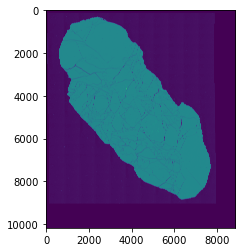

In [44]:
stitched_boosted = stitched*65535
to_save = stitched_boosted.astype(np.uint16)
#to_save = (lines_removed.copy()-np.min(lines_removed))*256*256*(1/(np.max(lines_removed)-np.min(lines_removed)))
#to_save = to_save.astype(np.uint16)
plt.imshow(stitched)
#to_save = Image.fromarray(to_save)
#to_save.save('un_brightened.png')

In [50]:
lower_threshold = 100*256
upper_threshold = 140*256
#testing_thresholding = top_left_stitched*256*256
testing_thresholding = stitched_boosted.copy()
#testing_thresholding = plt.imread("./line_removed.png")*256*256
testing_thresholding[testing_thresholding>upper_threshold] = upper_threshold
testing_thresholding[testing_thresholding<lower_threshold] = lower_threshold
testing_thresholding = (testing_thresholding -(lower_threshold))*(256*256/(upper_threshold-lower_threshold))
testing_thresholding_image = testing_thresholding.astype(np.uint16)
testing_thresholding_image = Image.fromarray(testing_thresholding_image)
name = 'John2_offset_20x_thresh.png'
testing_thresholding_image.save(name)
os.system("start "+name)


0

In [48]:
stitched = 0

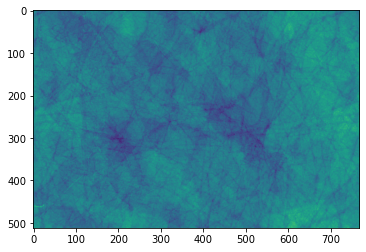

In [78]:
plt.imshow(np.mean(ims_brightened, 0))

In [76]:
grid_check_x = get_tile_x(inboard_tile_numbers[4])
grid_check_y = get_tile_y(inboard_tile_numbers[4])        

2

In [2]:
stitched = plt.imread("geo_mean_fixed_rerun_lwremoved.png")

In [17]:
ims[17]

array([[0.04081788, 0.03099107, 0.03472953, ..., 0.04705882, 0.03198291,
        0.03617914],
       [0.02430762, 0.04779126, 0.02928206, ..., 0.04760815, 0.04808118,
        0.04406806],
       [0.0475166 , 0.02987717, 0.02876326, ..., 0.04324407, 0.04597543,
        0.05528343],
       ...,
       [0.03854429, 0.03915465, 0.05381857, ..., 0.0405127 , 0.03564508,
        0.05079728],
       [0.02658122, 0.03260853, 0.04411383, ..., 0.04415961, 0.04069581,
        0.06216526],
       [0.03201343, 0.03845274, 0.03562982, ..., 0.04100099, 0.05278096,
        0.03926146]], dtype=float32)

In [18]:
#stitched = plt.imread("./tedge_sep.png")
relative_values = []
for i in inboard_tile_numbers:
    left_tile_brightness, right_tile_brightness, tile_1_point, x_size_limit, y_size_limit = stitcher_brightness_evaluator(get_tile_point(i), get_tile_point(i+1))
    tile_horizontal_position = get_tile_x(i)
    tile_vertical_position = get_tile_y(i)
    start_pixel_vertical_position = tile_1_point[1]
    start_pixel_horizontal_position = tile_1_point[0]
    target_pixel_horizontal_position = ((start_pixel_horizontal_position + (tile_horizontal_position*(horizontal_size-horizontal_overlap))) - horizontal_rowwise_tuning[tile_vertical_position]) - horizontal_columnwise_tuning[tile_horizontal_position] - smallest_horizontal_offset+horizontal_dont_wrap
    target_pixel_vertical_position = start_pixel_vertical_position + (tile_vertical_position*(vertical_size-vertical_overlap)) - vertical_rowwise_tuning[tile_vertical_position] - vertical_columnwise_tuning[tile_vertical_position] - smallest_vertical_offset+vertical_dont_wrap
    target_pixel_horizontal_position = int(target_pixel_horizontal_position)
    target_pixel_vertical_position = int(target_pixel_vertical_position)
    target_position = np.array((target_pixel_horizontal_position,target_pixel_vertical_position))

    overlapping_brightness, junk = get_stitched_brightness(target_position, x_size_limit, y_size_limit-70)
    overlapping_left_brightness, junk = get_stitched_brightness(target_position-[x_size_limit*2,0], x_size_limit, y_size_limit-70)
    overlapping_right_brightness, junk = get_stitched_brightness(target_position+[x_size_limit*2,0], x_size_limit, y_size_limit-70)
    print(overlapping_brightness*256,((left_tile_brightness+right_tile_brightness)/2)*256,(overlapping_brightness-(left_tile_brightness+right_tile_brightness)/2)*256, (((overlapping_left_brightness+overlapping_right_brightness)/2)-overlapping_brightness)*256)
    relative_values.append((((overlapping_left_brightness+overlapping_right_brightness)/2)-overlapping_brightness)*256)
    #check_stitched_brightness_position(target_position, x_size_limit, y_size_limit-70,1)
    
    
#    check_stitched_brightness_position(target_position, 20, 50, 0)    
#    target_position = target_position - np.array((100, 0))
#    non_overlapping_brightness, junk = get_stitched_brightness(target_position, 20, 50)
#    check_stitched_brightness_position(target_position, 20, 50, 1)
#    print(overlapping_brightness-non_overlapping_brightness)
#    relative_values.append((overlapping_brightness-non_overlapping_brightness))
#    #plt.imshow(stitched[target_position[1]-500:target_position[1]+500,target_position[0]-500:target_position[0]+500])
relative_values = np.array(relative_values)

NameError: name 'stitcher_brightness_evaluator' is not defined

In [86]:
print(np.min(relative_values))
print(np.max(relative_values))
print(np.mean(relative_values))

-23.974578857421875
5.245941162109375
-0.12118275960286458


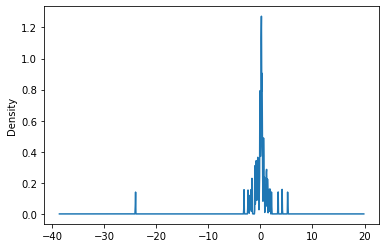

In [92]:
series = pd.Series(relative_values)
ax = series.plot.kde(bw_method = 0.01)


In [132]:
fft_output = np.fft.fftshift(np.fft.rfft2(stitched))

In [133]:
fft_output.shape

(10178, 4427)

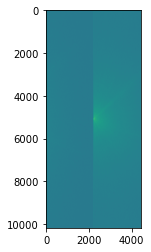

In [134]:
plt.imshow(np.log(np.abs(fft_output)**2))

In [3]:
#import numpy as np
from scipy.ndimage import convolve1d
from scipy.signal import firwin, welch

def remove_lines(image, distortion_freq=None, num_taps=65, eps=0.025):
  """Removes horizontal line artifacts from scanned image.
  Args:
    image: 2D or 3D array.
    distortion_freq: Float, distortion frequency in cycles/pixel, or
      `None` to estimate from spectrum.
    num_taps: Integer, number of filter taps to use in each dimension.
    eps: Small positive param to adjust filters cutoffs (cycles/pixel).
  Returns:
    Denoised image.
  """
  image = np.asarray(image, float)
  if distortion_freq is None:
    distortion_freq = estimate_distortion_freq(image)

  hpf = firwin(num_taps, distortion_freq - eps,
               pass_zero='highpass', fs=1)
  lpf = firwin(num_taps, eps, pass_zero='lowpass', fs=1)
  return image - convolve1d(convolve1d(image, hpf, axis=0), lpf, axis=1)

def estimate_distortion_freq(image, min_frequency=1/25):
  """Estimates distortion frequency as spectral peak in vertical dim."""
  f, pxx = welch(np.reshape(image, (len(image), -1), 'C').sum(axis=1))
  pxx[f < min_frequency] = 0.0
  return f[pxx.argmax()]

In [10]:
lines_removed = remove_lines(stitched, distortion_freq = 1/(512-vertical_overlap), eps = 0.0001)

In [11]:
lines_removed.shape

(10178, 8853)

In [131]:
np.max(fft_output)

(16436705.661197757-2.0014567780890502e-10j)

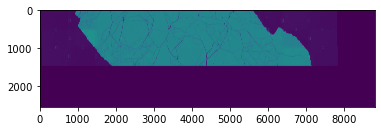

In [46]:
plt.imshow(stitched_boosted)

In [83]:
np.min(stitched_boosted)

0.0

In [36]:
full_set

0          0.292536
1          0.382247
2          0.422059
3          0.437021
4          0.452318
             ...   
7441744    0.262236
7441745    0.364000
7441746    0.427220
7441747    0.434818
7441748    0.407054
Length: 7441749, dtype: float64

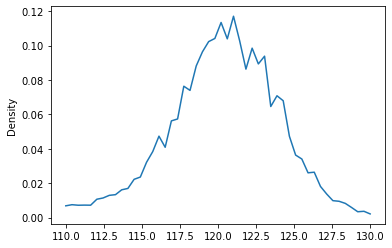

In [214]:
are_you_sure = 1
if are_you_sure == 1:
    full_set = pd.Series((stitched.flatten()[stitched.flatten()>(50/256)])*256)

evaluate_at = np.linspace(110, 130, 50)
ax = full_set.plot.kde(bw_method = 0.0001, ind=evaluate_at)

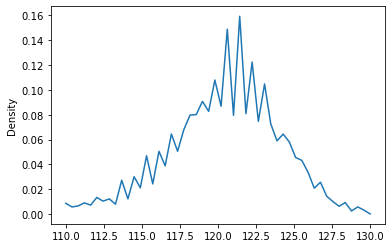

In [223]:
are_you_sure = 1
if are_you_sure == 1:
    full_set = pd.Series((ims_brightened_overall[1,4].flatten()[ims_brightened_overall[1,4].flatten()>(50/256)])*256)
evaluate_at = np.linspace(110, 130, 50)
ax = full_set.plot.kde(bw_method = 0.00015, ind=evaluate_at)

In [52]:
top_left_stitched = plt.imread("./top_left_origin.png")

In [54]:
np.max(top_left_stitched)

0.9996643

In [17]:
np.min(lines_removed)

-0.5022851030991103

In [4]:
lower_threshold = 110*256
upper_threshold = 130*256
testing_thresholding = stitched*256*256
#testing_thresholding = stitched_boosted.copy()
#testing_thresholding = plt.imread("./line_removed.png")*256*256
testing_thresholding[testing_thresholding>upper_threshold] = upper_threshold
testing_thresholding[testing_thresholding<lower_threshold] = lower_threshold
testing_thresholding = (testing_thresholding -(lower_threshold))*(256*256/(upper_threshold-lower_threshold))
testing_thresholding_image = testing_thresholding.astype(np.uint16)
testing_thresholding_image = Image.fromarray(testing_thresholding_image)
testing_thresholding_image.save('showing_jmac_thresh.tif')

In [14]:
lower_threshold = 116*256
upper_threshold = 125*256
thresholds = np.linspace(110*256, 150*256, 100)
#lower_thresholds = np.linspace(110, 125, 100)
copy =  plt.imread("./line_removed.png")*256*256
frac_above_threshold = np.array(([np.count_nonzero(copy>=x) for x in thresholds]))/np.count_nonzero(copy>=110*256)

In [15]:
for i in range(len(frac_above_threshold)-1):
    if frac_above_threshold[i]>0.99 and frac_above_threshold[i+1]<0.99:
        print(np.min(thresholds)/256+(0.2*i), frac_above_threshold[i], "Should be lower threshold")
    if frac_above_threshold[i]>0.01 and frac_above_threshold[i+1]<0.01:
        print(np.min(thresholds)/256+(0.2*(i+1)), frac_above_threshold[i+1], "Should be upper threshold")
    

110.0 1.0 Should be lower threshold


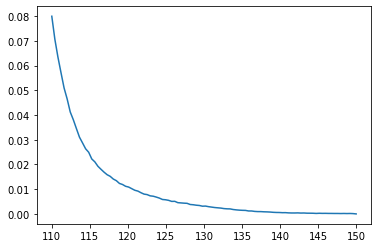

In [16]:
d_frac_d_thresh = []
for i in range(len(frac_above_threshold)-1):
    d_frac_d_thresh.append(frac_above_threshold[i]-frac_above_threshold[i+1])
d_frac_d_thresh.append(0)
p1 = plt.plot(thresholds/256, d_frac_d_thresh)

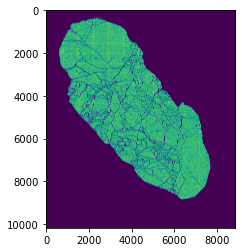

In [124]:
plt.imshow(testing_thresholding)

In [145]:
get_tile_point(17)

(6, 1)

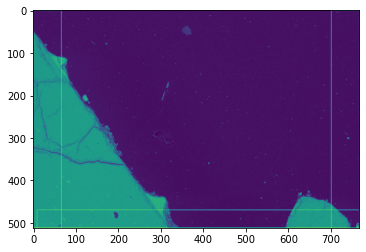

In [146]:
plt.imshow(ims_brightened[8])

In [82]:
np.min(testing_thresholding-lower_threshold)

0.0

In [66]:
testing_thresholding

array([[25600., 25600., 25600., ..., 25600., 25600., 25600.],
       [25600., 25600., 25600., ..., 25600., 25600., 25600.],
       [25600., 25600., 25600., ..., 25600., 25600., 25600.],
       ...,
       [25600., 25600., 25600., ..., 25600., 25600., 25600.],
       [25600., 25600., 25600., ..., 25600., 25600., 25600.],
       [25600., 25600., 25600., ..., 25600., 25600., 25600.]])

In [3]:
overall_brightness_tracker

NameError: name 'overall_brightness_tracker' is not defined

In [105]:
np.max(bottom_right_stitched_thresh-top_left_stitched_thresh)


65535

In [29]:
bottom_right_stitched_thresh = plt.imread("./bottom_right_origin_thresholded")

FileNotFoundError: [Errno 2] No such file or directory: './bottom_right_origin_thresholded'

In [ ]:
top_left_stitched_thresh = plt.imread("./top_left_origin_thresholded.tif")

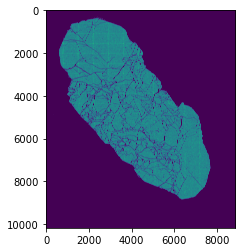

In [103]:
plt.imshow((bottom_right_stitched_thresh+top_left_stitched_thresh))

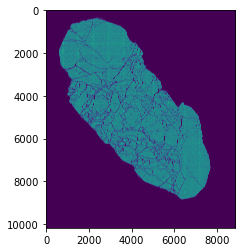

In [112]:
plt.imshow((top_left_stitched_thresh+bottom_right_stitched_thresh)+20)

In [ ]:
plt.imshow(bottom_right_stitched_thresh)

In [ ]:
for i in 